In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import optuna


import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    ElasticNet, 
    Lasso,
    LinearRegression,
    Ridge
)
from scipy.stats import norm, skew, boxcox_normmax #for some statistics
from sklearn import utils
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, f_regression
from scipy.special import boxcox1p

import datetime
import time

In [2]:
import xgboost as xgb

In [3]:
def log_mlflow(model):
    # Track params and metrics 
    with mlflow.start_run() as run:
        mlflow.set_tag("model_name", name)
        mlflow.log_param("CV_n_folds", CV_n_folds)
        mlflow.log_param("TEST_PART", TEST_PART)
        mlflow.log_param("Train size", X_train.shape)
        mlflow.log_param("Colums", str(X_train.columns.values.tolist()))
        mlflow.log_metrics({'rmse_cv': score_cv.mean(), 'rmse': score})
        mlflow.log_metric("rmse_train", score_train)
        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)
    mlflow.end_run()

In [4]:
# Note:  We can't set this here due to https://github.com/mlflow/mlflow/issues/608
#tracking_uri='file:///mnt/pipelineai/users/experiments'
from mlflow import log_metric, log_param, log_artifact
import mlflow.sklearn
import mlflow.xgboost

experiment_name = 'house_price'
mlflow.set_experiment(experiment_name)
# Forcing an end_run() to prevent 
#    https://github.com/mlflow/mlflow/issues/1335 
#    https://github.com/mlflow/mlflow/issues/608
mlflow.end_run()

artifact_path = mlflow.get_artifact_uri()
uri = mlflow.tracking.get_tracking_uri()
print(artifact_path)
print(uri)

INFO: 'house_price' does not exist. Creating a new experiment
file:///C:/mlflow%20house%20price/mlruns/1/2ab9d202723a469e8505ad1f373c8f1d/artifacts
file:///C:/mlflow%20house%20price/mlruns


In [5]:
mlflow.end_run()

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
print ("Size ntrain= {} / ntest = {}".format(train.shape, test.shape))

Size ntrain= (1460, 81) / ntest = (1459, 80)


In [11]:
### GROUP TRAIN AND TEST DATASETS
ntrain = train.shape[0]
ntest = test.shape[0]
print ("Size ntrain= {} / ntest = {}".format(ntrain, ntest))
# all_data = pd.concat((train, test)).reset_index(drop=True)
all_data = train.append(test, sort=False).reset_index(drop=True)
#To save original ID for final submission
orig_test = test.copy() 
log_y_train = train['SalePrice']
# To avoid normalization of SalesPrice - drop it from All data 
all_data.drop(['SalePrice'], axis=1, inplace=True)
# Id no need for traning
all_data.drop(['Id'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

Size ntrain= 1453 / ntest = 1459
all_data size is : (2912, 79)


In [12]:
### SHOW HOW MUCH STATISTIC DATA IS MISSING
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.690934
MiscFeature,96.428571
Alley,93.269231
Fence,80.391484
FireplaceQu,48.695055
LotFrontage,16.655220
GarageFinish,5.425824
GarageQual,5.425824
GarageCond,5.425824
GarageYrBlt,5.425824


In [13]:
#### DATA CORRELATION
threshold = 0.90
# Absolute value correlation matrix
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# upper.head(50)
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d features to remove.' % (len(collinear_features)))
print(collinear_features)


There are 0 features to remove.
[]


In [14]:
### IMPUTING MISSING VALUES
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
# Raplace null with None value.
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

all_data = all_data.drop(['Utilities'], axis=1)

In [15]:
### GENERATING NEW FEATURES
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Categorial and quantative features investigation
### Convert str in Quality features to int

In [16]:
def convert_str_to_int(data, features, score):
    all_data[features] = all_data[features].applymap(lambda s: score.get(s) if s in score else s)

featuresQualCond = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual",
                    "FireplaceQu", "HeatingQC", "GarageQual", "GarageCond", "PoolQC"]
qual_score_QualCond = {"None":0, "NA":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6}
convert_str_to_int(all_data, featuresQualCond, qual_score_QualCond)

featuresExposure = ["BsmtExposure"]
qual_score = {"None":0, "NA":1, "No":2, "Mn":3, "Av":4, "Gd":5}
convert_str_to_int(all_data, featuresExposure, qual_score)

featuresFinType = ["BsmtFinType1", "BsmtFinType2"]
qual_score = {"None":0, "NA":1, "Unf":2, "LwQ":3, "Rec":4, "BLQ":5, "ALQ":6, "GLQ":7}
convert_str_to_int(all_data, featuresFinType, qual_score)

featuresGarageFin = ["GarageFinish"]
qual_score = {"None":0, "NA":1, "Unf":2, "RFn":3, "Fin":4}
convert_str_to_int(all_data, featuresGarageFin, qual_score)

### Some features should be categorial

In [17]:
#MSSubClass=The building class represented as int but it's category
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Label Encoding
some categorical variables that may contain information in their ordering set

In [18]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2912, 79)


### Skewed features
### Box Cox Transformation of (highly) skewed features

In [19]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skew_features = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Skew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skew_features})

skewness = skewness[abs(skew_features) > 0.05]
print("There are {} high skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
for i in skewed_features:
    all_data[i] = boxcox1p(all_data[i], 0.15)
print('Shape all_data: {}'.format(all_data.shape))

Skew in numerical features: 

There are 57 high skewed numerical features to Box Cox transform
Shape all_data: (2912, 79)


In [34]:

###convert categorical variable into dummy
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2912, 215)


In [35]:
cols = ('Condition_RRNn', 'Condition_RRAe', 
        'Condition_Artery', 'Condition_Feedr', 'Condition_Feedr', 'Condition_RRNe', 
        'Condition_PosA', 'Condition_Norm', 'Condition_RRAn', 
        'Condition_PosN')
# process columns, apply LabelEncoder to categorical features
lbl = LabelEncoder()
for c in cols:
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(all_data[c].values)       
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2912, 215)


In [36]:
### drop low important features
todrop = ['GarageType_BuiltIn', 'MiscFeature_None', 'PoolQC', 'MiscVal', 'Condition_RRAn', 'Neighborhood_BrDale', 'GarageType_2Types', 'Exterior1st_Stucco', 'Neighborhood_Blmngtn', 'LotConfig_FR3', 'Neighborhood_Timber', 'SaleType_ConLI', 'Condition_PosA', 'LandContour_Bnk', 'Alley_None', 'Street_Pave', 'Street_Grvl', 'Condition_Norm', 'Condition_RRNn', '3SsnPorch', 'BldgType_TwnhsE', 'RoofMatl_Membran', 'RoofMatl_WdShake', 'RoofMatl_Roll', 'RoofMatl_Metal', 'Exterior2nd_Stone', 'Exterior2nd_MetalSd', 'MasVnrType_None', 'Exterior2nd_ImStucc', 'LowQualFinSF', 'RoofMatl_Tar&Grv', 'Exterior2nd_AsphShn', 'Heating_GasA', 'HouseStyle_2.5Unf', 'Exterior2nd_AsbShng', 'Exterior1st_WdShing', 'BldgType_Duplex', 'Exterior2nd_CBlock', 'SaleType_Oth', 'Condition_PosN', 'Neighborhood_Veenker', 'BldgType_2fmCon', 'MiscFeature_TenC', 'Neighborhood_Blueste', 'RoofStyle_Mansard', 'Foundation_Slab', 'HouseStyle_SFoyer', 'Heating_Floor', 'HouseStyle_2.5Fin', 'Exterior1st_Stone', 'Exterior1st_CBlock']
print ("Before Drop = ", all_data.shape)
all_data.drop(todrop, axis=1, inplace=True)
print ("After Drop = ", all_data.shape)

Before Drop =  (2912, 215)
After Drop =  (2912, 164)


In [37]:
scaler = RobustScaler()
df_all = pd.DataFrame(scaler.fit_transform(all_data))

### Separate back train and test set

In [38]:
# all_data = all_data.iloc[:, 1:10]
# data.iloc[:, 0:2] # first two columns of data frame with all rows
train = all_data[:ntrain]
test = all_data[ntrain:]
colnames = train.columns

# Check remaining missing values if any 
train_na = (train.isnull().sum() / len(all_data)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head()

,Missing Ratio


In [39]:
# Log into a file train shape and columns names
f = open("models_training_log.txt", "a+")
print("\n-------------------" + str(datetime.datetime.now().isoformat()) + "-------------------", file=f)
print("Train shape:" + str(train.shape) , file=f)
print("feature names:" + str(list(colnames)) , file=f)
f.close()

In [40]:
### TRAINING MODEL
def rmsle_cv(model, X_train, y_train, cv_n_folds):
    kf = KFold(cv_n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def print_rmse_score(y, y_pred):
    score = rmse(y, y_pred)
    print("RMSE score: {:.8f}".format(score))
    return score

def print_rmse_cv_score(model, X_train, y_train, cv_n_folds, prefix=""):
    score = rmsle_cv(model, X_train, y_train, cv_n_folds)
    print(prefix + "CV RMSE score: {:.8f} ({:.4f})".format(score.mean(), score.std()))
    return score

def prepare_datasets(X_matrix, Y_vector, test_part):
    X_train = X_matrix
    y_train = Y_vector
    X_test = np.array([])
    y_test = np.array([])
    if test_part > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_matrix, Y_vector, random_state = 0, test_size = test_part)
            
    print ("\nTEST_PART = ",  test_part)
    print ("Train X| " + str(X_train.shape) + " Y| " + str(y_train.shape))
    print ("Test X| " + str(X_test.shape) + " Y| " + str(y_test.shape))
    return [X_train, y_train, X_test, y_test]

In [41]:
X = train.copy()
Y = log_y_train.copy()
X_submit = test.copy()

TEST_PART = 0.1
CV_n_folds = 3
[X_train, y_train, X_test, y_test] = prepare_datasets(X, Y, TEST_PART)


TEST_PART =  0.1
Train X| (1307, 164) Y| (1307,)
Test X| (146, 164) Y| (146,)


In [42]:
classifiers=set([])
models={}
scores_cv={}
scores={}
scores_train={}
submits={}

In [43]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [45]:
### RIDGE
%time
model_ridge = Ridge(alpha=5.75)
model = model_ridge.fit(X_train, y_train)
score_cv = score_ridge_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_ridge = print_rmse_score(y_test, model.predict(X_test))
ridge_submit = np.expm1(model.predict(X_submit))

name = "Ridge"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = ridge_submit
ranks[name] = ranking(np.abs(model.coef_), colnames)

log_mlflow(model)

Wall time: 0 ns
CV RMSE score: 0.11390861 (0.0087)
RMSE score: 0.11089278
RMSE score: 0.10085038


In [46]:
### GRADIENT BOOSTING REGRESSOR
%time
params = {
    'learning_rate': 0.01,
    "n_estimators":500,
    'max_depth': 3,
    'max_features': "sqrt",
    "loss":"huber",
    'min_samples_leaf': 12,
    'min_samples_split': 11,
    "random_state":5
}
model_GBoost = GradientBoostingRegressor(**params)
model = model_GBoost.fit(X_train, y_train)
score_cv = score_GBoost_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_GBoost = print_rmse_score(y_test, model.predict(X_test))
gboost_submit = np.expm1(model.predict(X_submit))

name = "GBoost"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = gboost_submit
ranks[name] = ranking(np.abs(model.feature_importances_), colnames)

log_mlflow(model)

Wall time: 0 ns
CV RMSE score: 0.13373862 (0.0121)
RMSE score: 0.14114656
RMSE score: 0.11615634


In [47]:
### KERNEL RIDGE
%time
model_KRR = KernelRidge(alpha=0.03525, 
                        kernel='polynomial', 
                        degree=1, coef0=1e-6)
model = model_KRR.fit(X_train, y_train)
score_cv = score_KRR_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_KRR = print_rmse_score(y_test, model.predict(X_test))
krr_submit = np.expm1(model.predict(X_submit))

name = "KRR"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = krr_submit

log_mlflow(model)

Wall time: 0 ns
CV RMSE score: 0.11322173 (0.0091)
RMSE score: 0.11106272
RMSE score: 0.10021332


In [48]:
### LIGHTGBM
%time
params = {'learning_rate': 0.01, 'num_leaves': 3, 'max_bin': 84,
          'bagging_freq': 1, 'bagging_seed': 2, 'feature_fraction_seed': 97, 
          'bagging_fraction': 0.745, "verbose":-1,
          'objective': 'regression',"n_estimators":1000
         }
model_lgbm = lgb.LGBMRegressor(**params)
model = model_lgbm.fit(X_train, y_train)
score_cv = score_lgbm_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_lgbm = print_rmse_score(y_test, model.predict(X_test))
lgbm_submit = np.expm1(model.predict(X_submit))

name = "lgbm"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = lgbm_submit
ranks[name] = ranking(np.abs(model.feature_importances_), colnames)
log_mlflow(model)

Wall time: 0 ns
[LightGBM] [Warning] bagging_fraction is set=0.745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
CV RMSE score: 0.12610619 (0.0097)
RMSE score: 0.13232228
RMSE score: 0.10984955


In [49]:
### XGBOOST
%time
model_xgb = xgb.XGBRegressor(tree_method="hist",
                             colsample_bytree=0.4603, gamma=0.01468, 
                             learning_rate=0.05187, max_depth=3, 
                             min_child_weight=0.0817, n_estimators=200,
                             reg_alpha=0.4640, reg_lambda=0.6571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model = model_xgb.fit(X_train, y_train)
score_cv = score_xgb_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_xgb = print_rmse_score(y_test, model.predict(X_test))
xgb_submit = np.expm1(model.predict(X_submit))

name = "xgb"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = xgb_submit
ranks[name] = ranking(np.abs(model.feature_importances_), colnames)

log_mlflow(model)

Wall time: 0 ns
[10:33:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:33:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:33:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used i

In [50]:
### LASSO
%time
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.00055419, random_state=1, max_iter=50000))
model = model_lasso.fit(X_train, y_train)
score_cv = score_lasso_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_lasso = print_rmse_score(y_test, model.predict(X_test))
lasso_submit = np.expm1(model.predict(X_submit))

name = "lasso"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = lasso_submit
ranks[name] = ranking(np.abs(model[1].coef_), colnames)

log_mlflow(model)

Wall time: 0 ns
CV RMSE score: 0.11251702 (0.0102)
RMSE score: 0.11409989
RMSE score: 0.10320191


In [52]:
### ELASTICNET
%time
params = {
    "alpha":0.00185,
    "max_iter":10000,
    "l1_ratio":0.224,
    "random_state":1
}
model_ENet = make_pipeline(RobustScaler(), ElasticNet(**params))
model = model_ENet.fit(X_train, y_train)
score_cv = score_ENet_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_ENet = print_rmse_score(y_test, model.predict(X_test))
ENet_submit = np.expm1(model.predict(X_submit))

name = "ENet"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = ENet_submit
ranks[name] = ranking(np.abs(model[1].coef_), colnames)

log_mlflow(model)

Wall time: 0 ns
CV RMSE score: 0.11253818 (0.0103)
RMSE score: 0.11468933
RMSE score: 0.10238494


### Model Stacking

In [53]:
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)
        return self

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append(np.exp(regressor.predict(X).ravel()))

        return np.log1p(np.mean(self.predictions_, axis=0))

In [54]:
# Averaged base models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [55]:
%time
model_averaged = AveragingModels(models = (model_ENet, 
                                            model_lasso, 
                                            model_GBoost,
                                            model_KRR))

model = model_averaged.fit(X_train, y_train)
score_cv = score_averaged_cv = print_rmse_cv_score(model, X_train, y_train, CV_n_folds)
score = score_averaged = print_rmse_score(y_test, model.predict(X_test))
averaged_models_submit = np.expm1(model.predict(X_submit))

name = "Averaged"
classifiers.add(name)
models[name] = model 
scores_cv[name] = score_cv
scores[name] = score
scores_train[name] = score_train = print_rmse_score(y_train, model.predict(X_train))
submits[name] = averaged_models_submit

log_mlflow(model)

Wall time: 0 ns
CV RMSE score: 0.11107274 (0.0098)
RMSE score: 0.11196056
RMSE score: 0.09993376


In [69]:
CV_score=[]
train_score=[]
Pred_score=[]
score_list=[]
log_y_test = np.expm1(y_test)
y_pred_df = pd.DataFrame({"test":log_y_test}).reset_index(drop=True)
std=[]

for i, name in enumerate(classifiers):
    model = models[name]
    if name != "Stacked":
        y_pred = np.expm1(model.predict(X_test))
    else:
        y_pred = np.expm1(model.predict(X_test.values))
    CV_score.append(scores_cv[name].mean())
    std.append(scores_cv[name].std())
    Pred_score.append(scores[name])
    train_score.append(scores_train[name])
    score_list.append(scores_cv[name])
    
    new_y_pred = pd.DataFrame({name:y_pred})
    y_pred_df = pd.concat([y_pred_df, new_y_pred], axis=1).reset_index(drop=True)
    y_pred_df["del_"+name] = y_pred_df["test"] - y_pred_df[name]
   
    
new_models_dataframe2=pd.DataFrame({"RMSE":Pred_score, "Train - RMSE":train_score,'CV Mean':CV_score,'Std':std}, index=classifiers) 
print("\nTEST_PART=", TEST_PART)
print("CV_n_folds=", CV_n_folds)
print(new_models_dataframe2)
print("\nMin RMSE score: {:.5f}".format(new_models_dataframe2["RMSE"].min()))
print("Min CV mean score: {:.5f}".format(new_models_dataframe2["CV Mean"].min()))

# Log into a file iteration score
f = open("models_training_log.txt", "a")
print("TEST_PART=", TEST_PART, file=f)
print("CV_n_folds=", CV_n_folds, file=f)
print(new_models_dataframe2, file=f)
print("\nMin RMSE score: {:.5f}".format(new_models_dataframe2["RMSE"].min()), file=f)
print("Min CV mean score: {:.5f}".format(new_models_dataframe2["CV Mean"].min()), file=f)
f.close()


TEST_PART= 0.1
CV_n_folds= 3
              RMSE  Train - RMSE   CV Mean       Std
lgbm      0.132322      0.109850  0.126106  0.009665
ENet      0.114689      0.102385  0.112538  0.010320
Ridge     0.110893      0.100850  0.113909  0.008733
GBoost    0.141147      0.116156  0.133739  0.012126
xgb       0.119063      0.092632  0.125085  0.008048
Averaged  0.111961      0.099934  0.111073  0.009845
KRR       0.111063      0.100213  0.113222  0.009134
lasso     0.114100      0.103202  0.112517  0.010175

Min RMSE score: 0.11089
Min CV mean score: 0.11107


In [71]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

C:\Users\Vaibhav\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Vaibhav\anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


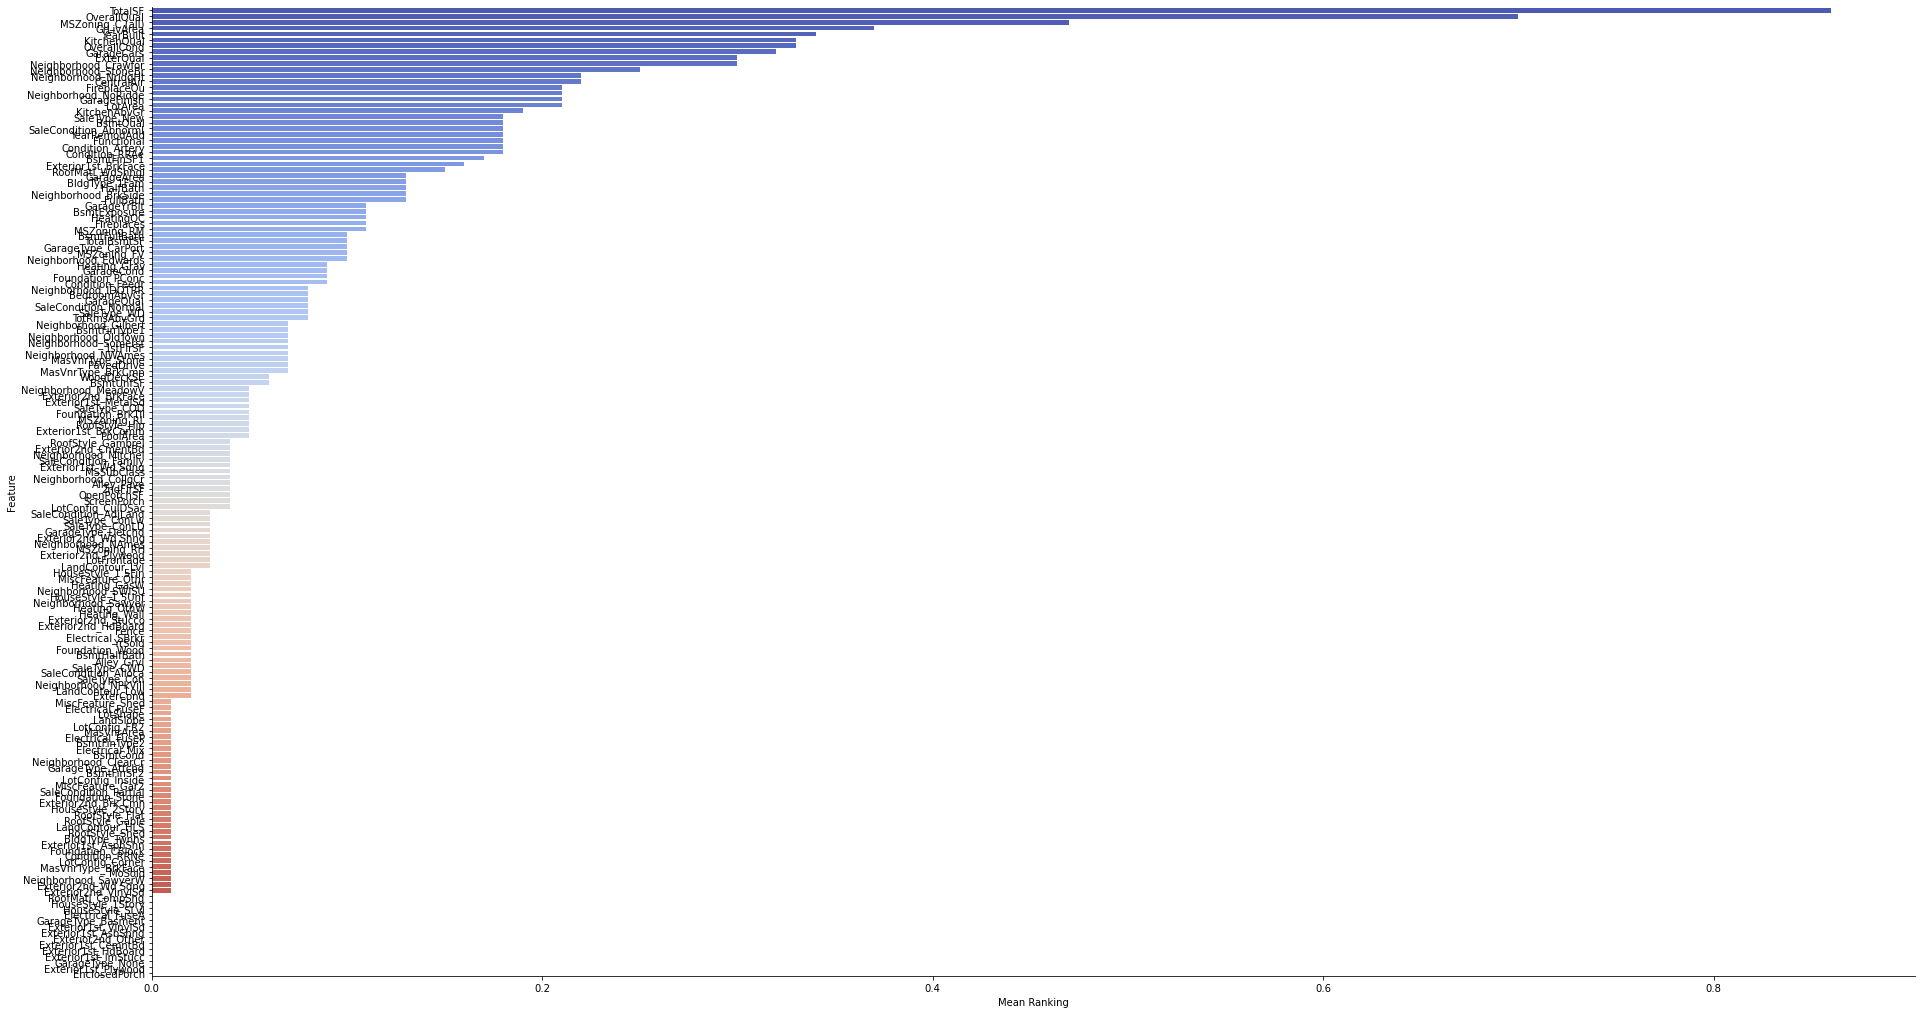

In [72]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')

In [73]:
todrop = list(meanplot[meanplot["Mean Ranking"]<0.02]["Feature"])
print ("Features to drop: {}".format(len(todrop)))
print (todrop)

Features to drop: 47
['MiscFeature_Shed', 'Electrical_FuseF', 'LotShape', 'LandSlope', 'LotConfig_FR2', 'MasVnrArea', 'Electrical_FuseP', 'BsmtFinType2', 'Electrical_Mix', 'BsmtCond', 'Neighborhood_ClearCr', 'GarageType_Attchd', 'BsmtFinSF2', 'LotConfig_Inside', 'MiscFeature_Gar2', 'SaleCondition_Partial', 'Foundation_Stone', 'Exterior2nd_Brk Cmn', 'HouseStyle_2Story', 'RoofStyle_Flat', 'RoofStyle_Gable', 'LandContour_HLS', 'RoofStyle_Shed', 'BldgType_Twnhs', 'Exterior1st_AsphShn', 'Foundation_CBlock', 'Condition_RRNe', 'LotConfig_Corner', 'MasVnrType_BrkFace', 'MoSold', 'Neighborhood_SawyerW', 'Exterior2nd_Wd Sdng', 'Exterior2nd_VinylSd', 'RoofMatl_CompShg', 'HouseStyle_1Story', 'HouseStyle_SLvl', 'Electrical_FuseA', 'GarageType_Basment', 'Exterior1st_VinylSd', 'Exterior1st_AsbShng', 'Exterior2nd_Other', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'GarageType_None', 'Exterior1st_Plywood', 'EnclosedPorch']


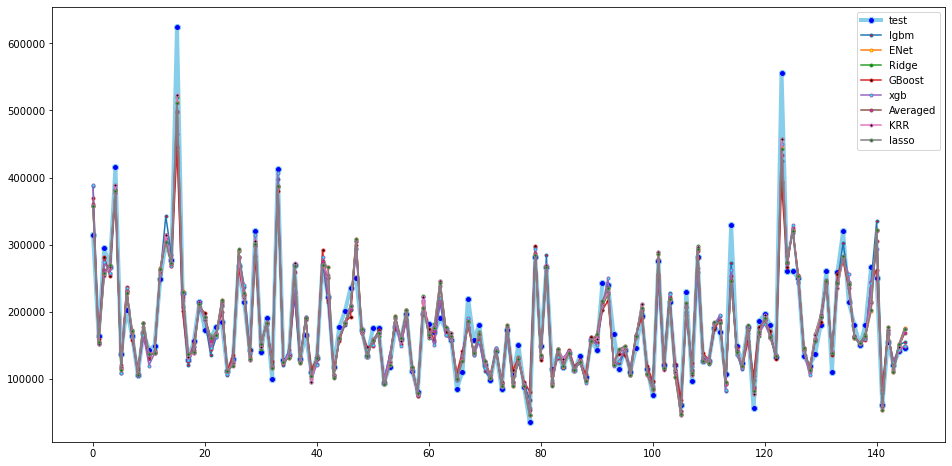

In [74]:

###Show how real prise from Test set corelated with Predicted price by models

plt.figure(figsize=(16, 8))
# multiple line plot
plt.plot(y_pred_df.index,'test', data=y_pred_df, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=4)

colors = ['red', 'yellow', 'green', 'black', 'cyan', 'magenta', 'black', 'green', 'black', 'cyan', 'magenta', 'black']
for i, name in enumerate(classifiers):
    plt.plot(y_pred_df.index, name, data=y_pred_df, marker='o', markerfacecolor=colors[i], markersize=3)

plt.legend()

ValueError: Unrecognized character S in format string

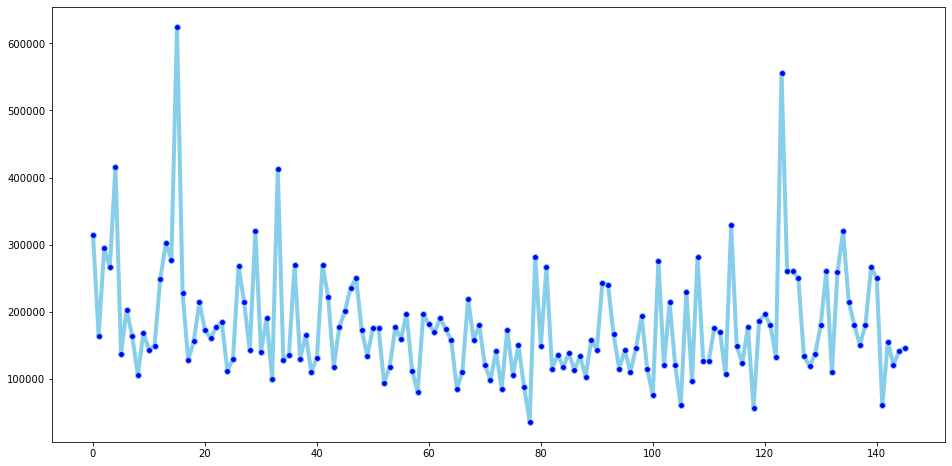

In [75]:

###Show just selected models
plt.figure(figsize=(16, 8))
# multiple line plot
plt.plot(y_pred_df.index,'test', data=y_pred_df, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=4)
# plt.plot(y_pred_df.index, "lasso", data=y_pred_df, marker='o', markerfacecolor="red", markersize=3)
plt.plot(y_pred_df.index, "Stacked", data=y_pred_df, marker='o', markerfacecolor="green", markersize=3)
# plt.plot(y_pred_df.index, "xgb", data=y_pred_df, marker='X', markerfacecolor="yellow", markersize=6)
plt.plot(y_pred_df.index, "lgbm", data=y_pred_df, marker='X', markerfacecolor="yellow", markersize=6)

plt.legend()

ValueError: Unrecognized character e in format string

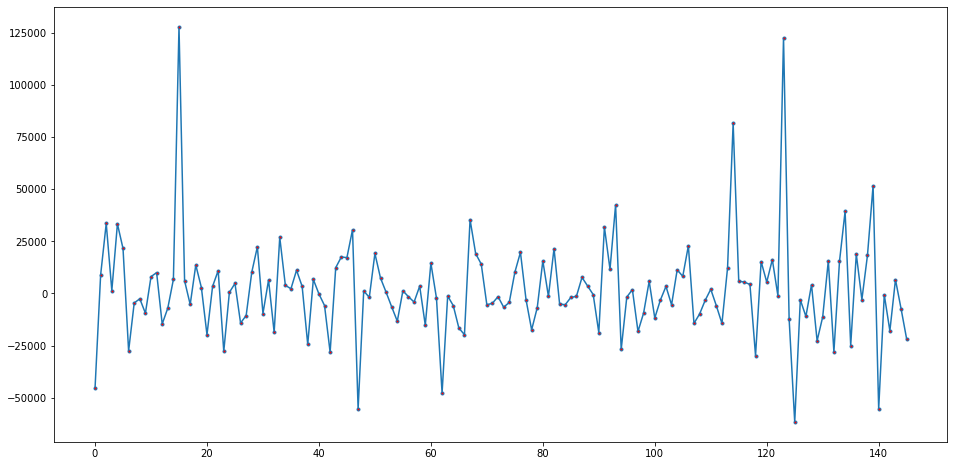

In [76]:
###Show delta between real price and predicted

plt.figure(figsize=(16, 8))
# multiple line plot
# plt.plot(y_pred_df.index,'test', data=y_pred_df, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=4)
plt.plot(y_pred_df.index, "del_Averaged", data=y_pred_df, marker='o', markerfacecolor="red", markersize=3)
plt.plot(y_pred_df.index, "del_Stacked", data=y_pred_df, marker='o', markerfacecolor="green", markersize=3)
# plt.plot(y_pred_df.index, "del_xgb", data=y_pred_df, marker='X', markerfacecolor="yellow", markersize=6)
plt.plot(y_pred_df.index, "del_lgbm", data=y_pred_df, marker='X', markerfacecolor="yellow", markersize=6)
# plt.plot(y_pred_df.index, "del_lasso", data=y_pred_df, marker='X', markerfacecolor="red", markersize=6)

plt.legend()